In [21]:
%load_ext autoreload
%autoreload 2

from scipy.stats import binom, beta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from contamination_estimation import VariantPosition, estimate_contamination, CONTAMINATION_RANGE
# https://github.com/liguowang/dcon/blob/master/lib/DconModule/utils.py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
VariantPosition(100,90,"HOM").log_contam_probability(0.1)

-2.02597397686619

In [49]:
def plot_result(vp, dist, sorted_likelihoods):
    fig = plt.figure(figsize=(10,4))
    ax=fig.add_subplot(121)
    ys = [v.alt_depth/v.total_depth for v in vp]
    sns.distplot(ys, ax=ax, hist=False)
 
    ax=fig.add_subplot(122)
    ax.plot(list(dist.keys()), list(dist.values()))
    ax.vlines(x = sorted_likelihoods[-1][0], ymin=-1000, ymax=0, color='red')
    fig.tight_layout()
    sns.despine()

Simulating: 0.0; Estimated: 0.008


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.05; Estimated: 0.056
Simulating: 0.1; Estimated: 0.111


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.15000000000000002; Estimated: 0.156


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.2; Estimated: 0.203


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.25; Estimated: 0.256


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.30000000000000004; Estimated: 0.301


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.35000000000000003; Estimated: 0.356


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.4; Estimated: 0.399
Simulating: 0.45; Estimated: 0.399


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


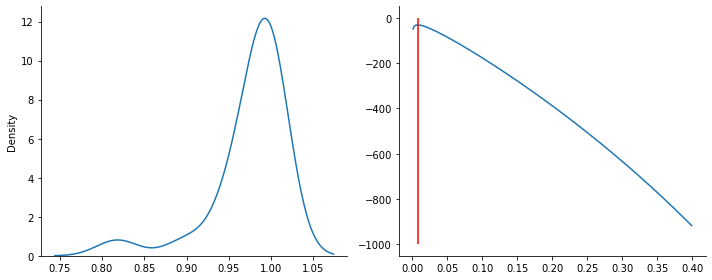

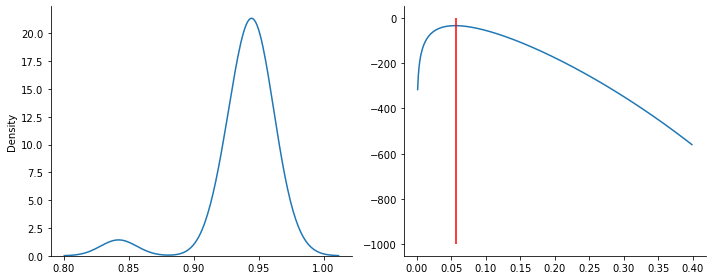

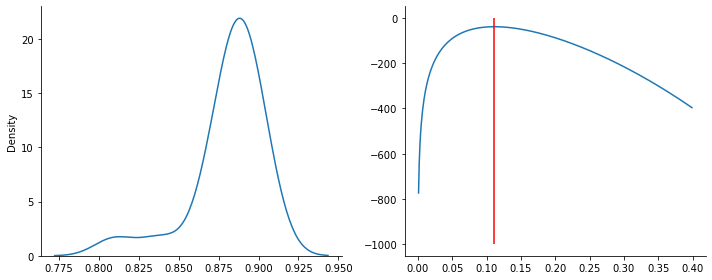

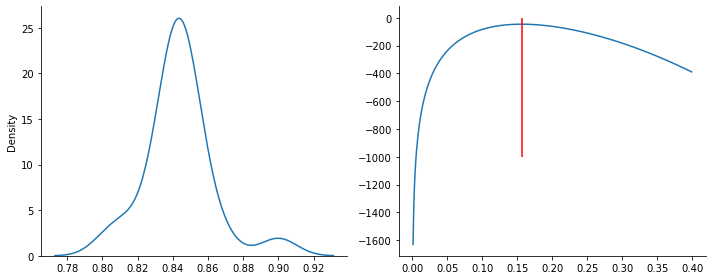

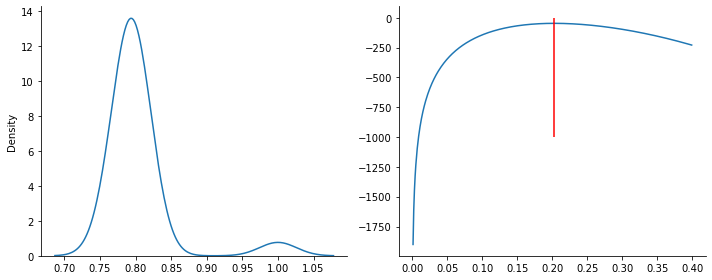

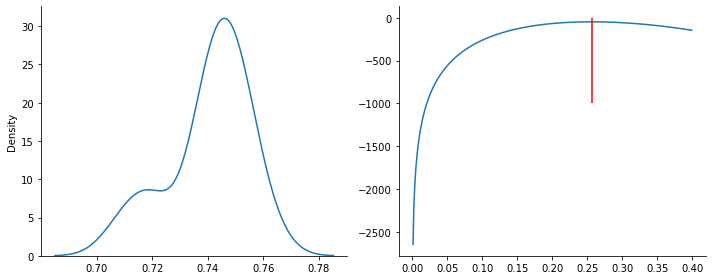

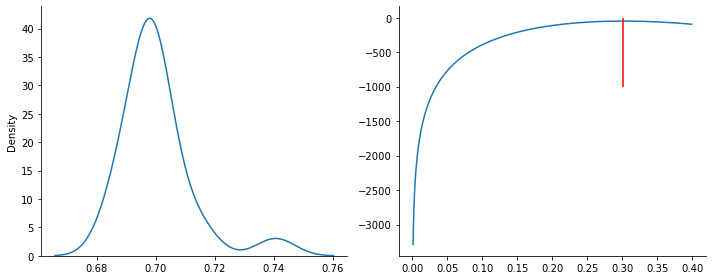

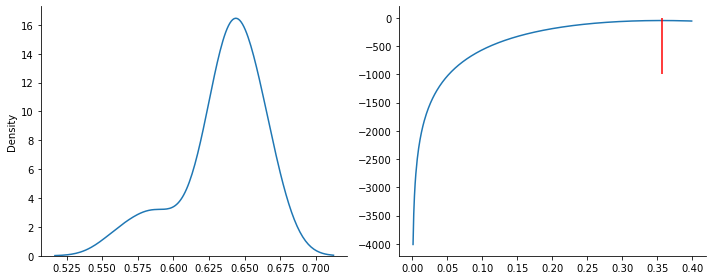

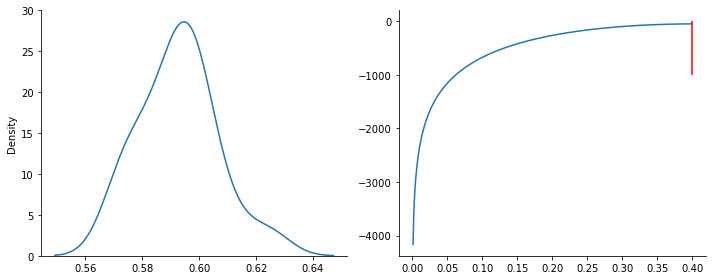

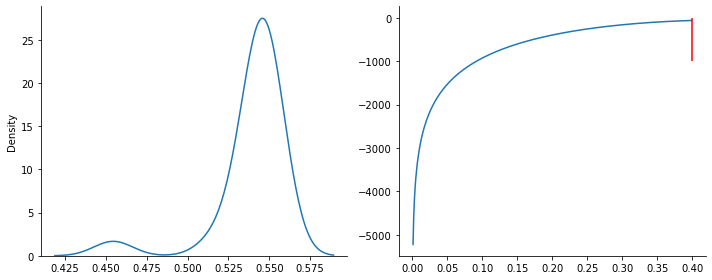

In [50]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HOM
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        alt_depth = total_depth - max(0, total_depth - np.random.normal(loc=total_depth * (1-simulated_contam) ))
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HOM')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    plot_result(vp, dist, sorted_likelihoods)
    

Simulating: 0.0; Estimated: 0.015


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.05; Estimated: 0.063


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.1; Estimated: 0.107


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.15000000000000002; Estimated: 0.169


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.2; Estimated: 0.394


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.25; Estimated: 0.374


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.30000000000000004; Estimated: 0.34900000000000003


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.35000000000000003; Estimated: 0.365


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.4; Estimated: 0.299


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Simulating: 0.45; Estimated: 0.27


/Users/wckdouglas/code/mambaforge/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


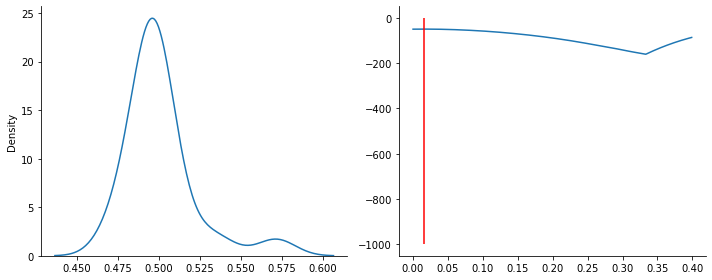

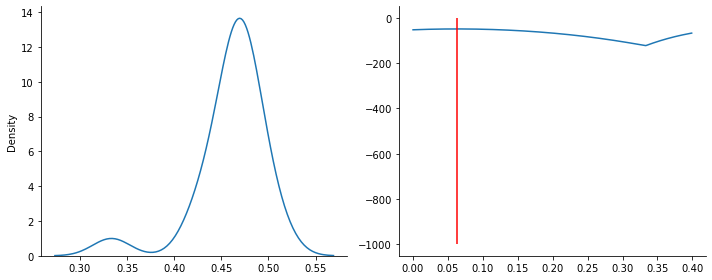

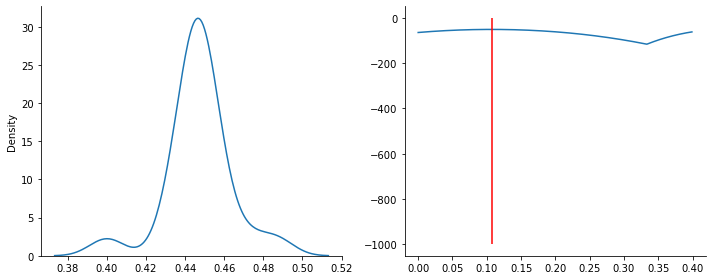

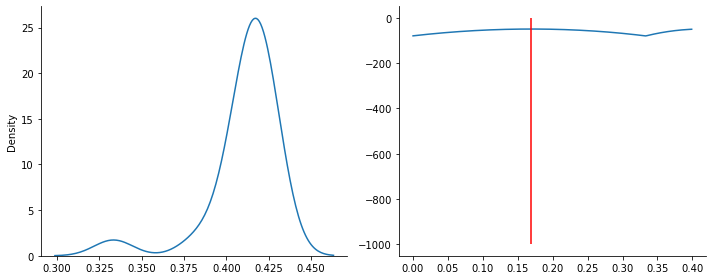

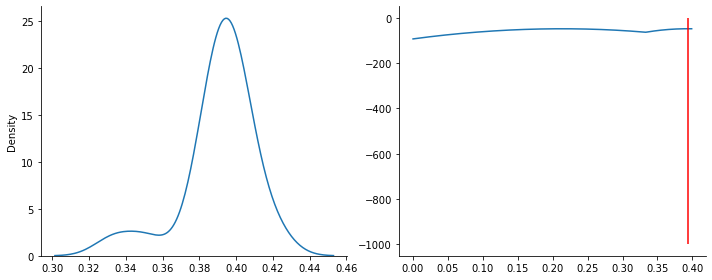

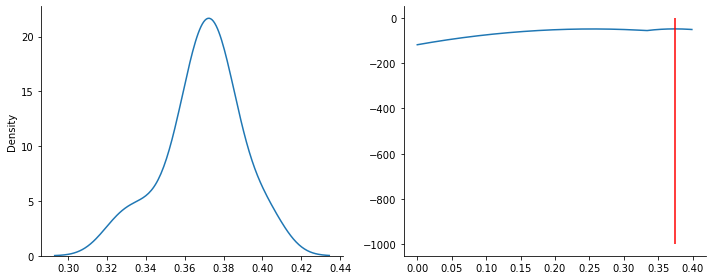

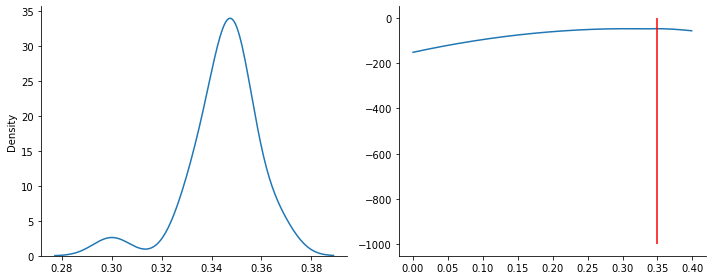

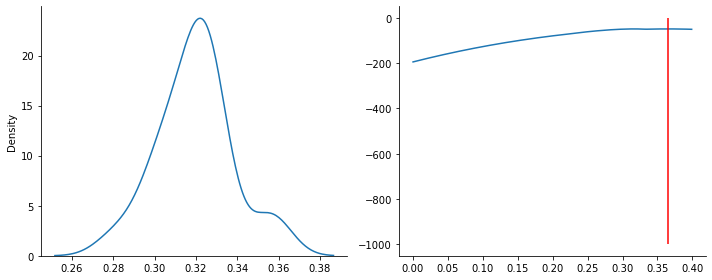

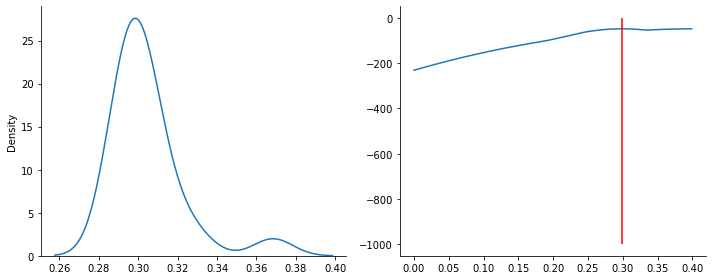

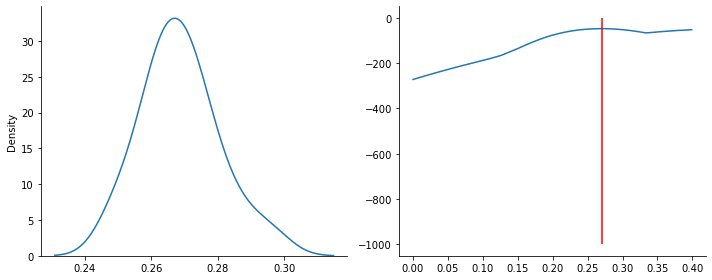

In [51]:
for simulated_contam in np.arange(0,0.5, 0.05):

    # simulate data HET
    vp = []
    for i in range(20):
        total_depth = np.random.randint(10,200)
        allele1_fraction = total_depth * 0.5
        alt_depth = total_depth / 2 
        alt_depth = np.random.normal(loc=alt_depth * (1-simulated_contam) )

        
        vp.append(
            VariantPosition(total_depth, alt_depth, 'HET')
        )
    
    dist=estimate_contamination(vp)
    sorted_likelihoods = sorted(dist.items(), key=lambda k: k[1]) # ascending sort
    print(f"Simulating: {simulated_contam}; Estimated: {sorted_likelihoods[-1][0]}")
    
    plot_result(vp, dist, sorted_likelihoods)

0.0